In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap


import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=500
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-resnet50-avgpool-Adam-500epochs-fromscratch.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(1):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    base_model = ResNet50(weights=None, input_shape=image_shape, include_top=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(Dense(num_classes, activation='softmax', name='predictions'))
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/500
8394/8394 [==============================] - 107s - loss: 0.9227 - acc: 0.8081 - val_loss: 8.8589 - val_acc: 0.1132
Epoch 2/500
8394/8394 [==============================] - 91s - loss: 0.2955 - acc: 0.9220 - val_loss: 1.9714 - val_acc: 0.6444
Epoch 3/500
8394/8394 [==============================] - 88s - loss: 0.1474 - acc: 0.9606 - val_loss: 0.1909 - val_acc: 0.9492
Epoch 4/500
8394/8394 [==============================] - 88s - loss: 0.1142 - acc: 0.9678 - val_loss: 0.1561 - val_acc: 0.9577
Epoch 5/500
8394/8394 [==============================] - 88s - loss: 0.0889 - acc: 0.9722 - val_loss: 0.2567 - val_acc: 0.9005
Epoch 6/500
8394/8394 [==============================] - 88s - loss: 0.0666 - acc: 0.9770 - val_loss: 0.1910 - val_acc: 0.9566
Epoch 7/500
8394/8394 [==============================] - 91s - loss: 0.0761 - acc: 0.9786 - val_loss: 0.2900 - val_acc: 0.9365
Epoch 8/500
8394/8394 [==============================] - 90s - 

8394/8394 [==============================] - 90s - loss: 1.9222e-04 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9915
Epoch 65/500
8394/8394 [==============================] - 90s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0739 - val_acc: 0.9884
Epoch 66/500
8394/8394 [==============================] - 90s - loss: 0.0652 - acc: 0.9814 - val_loss: 3.8503 - val_acc: 0.6138
Epoch 67/500
8394/8394 [==============================] - 90s - loss: 0.0234 - acc: 0.9924 - val_loss: 0.0559 - val_acc: 0.9884
Epoch 68/500
8394/8394 [==============================] - 90s - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0612 - val_acc: 0.9884
Epoch 69/500
8394/8394 [==============================] - 90s - loss: 0.0210 - acc: 0.9949 - val_loss: 0.0582 - val_acc: 0.9831
Epoch 70/500
8394/8394 [==============================] - 90s - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0495 - val_acc: 0.9884
Epoch 71/500
8394/8394 [==============================] - 90s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0471 - v

8394/8394 [==============================] - 90s - loss: 2.6743e-04 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 0.9905
Epoch 127/500
8394/8394 [==============================] - 90s - loss: 1.0365e-04 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9915
Epoch 128/500
8394/8394 [==============================] - 90s - loss: 6.1287e-05 - acc: 1.0000 - val_loss: 0.0531 - val_acc: 0.9905
Epoch 129/500
8394/8394 [==============================] - 90s - loss: 5.7929e-05 - acc: 1.0000 - val_loss: 0.0526 - val_acc: 0.9915
Epoch 130/500
8394/8394 [==============================] - 90s - loss: 4.1618e-04 - acc: 0.9999 - val_loss: 0.0626 - val_acc: 0.9884
Epoch 131/500
8394/8394 [==============================] - 90s - loss: 0.0146 - acc: 0.9968 - val_loss: 0.0831 - val_acc: 0.9852
Epoch 132/500
8394/8394 [==============================] - 90s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0837 - val_acc: 0.9852
Epoch 133/500
8394/8394 [==============================] - 90s - loss: 8.9307e-04 - acc: 0.

8394/8394 [==============================] - 90s - loss: 2.2651e-05 - acc: 1.0000 - val_loss: 0.0952 - val_acc: 0.9884
Epoch 189/500
8394/8394 [==============================] - 90s - loss: 1.5785e-05 - acc: 1.0000 - val_loss: 0.0947 - val_acc: 0.9884
Epoch 190/500
8394/8394 [==============================] - 90s - loss: 9.4363e-05 - acc: 1.0000 - val_loss: 0.1028 - val_acc: 0.9862
Epoch 191/500
8394/8394 [==============================] - 90s - loss: 3.1784e-05 - acc: 1.0000 - val_loss: 0.0997 - val_acc: 0.9873
Epoch 192/500
8394/8394 [==============================] - 90s - loss: 2.4531e-05 - acc: 1.0000 - val_loss: 0.0990 - val_acc: 0.9852
Epoch 193/500
8394/8394 [==============================] - 90s - loss: 1.8113e-04 - acc: 0.9999 - val_loss: 0.0846 - val_acc: 0.9873
Epoch 194/500
8394/8394 [==============================] - 90s - loss: 1.7234e-05 - acc: 1.0000 - val_loss: 0.0805 - val_acc: 0.9894
Epoch 195/500
8394/8394 [==============================] - 90s - loss: 1.4227e-05 -

8394/8394 [==============================] - 90s - loss: 4.6238e-04 - acc: 0.9998 - val_loss: 0.0779 - val_acc: 0.9884
Epoch 251/500
8394/8394 [==============================] - 90s - loss: 5.0184e-04 - acc: 0.9999 - val_loss: 0.0750 - val_acc: 0.9894
Epoch 252/500
8394/8394 [==============================] - 90s - loss: 0.0063 - acc: 0.9987 - val_loss: 0.1165 - val_acc: 0.9852
Epoch 253/500
8394/8394 [==============================] - 90s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0897 - val_acc: 0.9884
Epoch 254/500
8394/8394 [==============================] - 90s - loss: 3.0203e-04 - acc: 0.9999 - val_loss: 0.0825 - val_acc: 0.9884
Epoch 255/500
8394/8394 [==============================] - 90s - loss: 5.0506e-05 - acc: 1.0000 - val_loss: 0.0904 - val_acc: 0.9894
Epoch 256/500
8394/8394 [==============================] - 90s - loss: 3.1675e-05 - acc: 1.0000 - val_loss: 0.0912 - val_acc: 0.9894
Epoch 257/500
8394/8394 [==============================] - 90s - loss: 1.9541e-05 - acc: 1.

8394/8394 [==============================] - 106s - loss: 6.2773e-06 - acc: 1.0000 - val_loss: 0.0869 - val_acc: 0.9852
Epoch 313/500
8394/8394 [==============================] - 99s - loss: 0.0079 - acc: 0.9985 - val_loss: 0.2994 - val_acc: 0.9714
Epoch 314/500
8394/8394 [==============================] - 96s - loss: 0.0121 - acc: 0.9970 - val_loss: 0.0922 - val_acc: 0.9862
Epoch 315/500
8394/8394 [==============================] - 104s - loss: 0.0026 - acc: 0.9988 - val_loss: 0.0885 - val_acc: 0.9862
Epoch 316/500
8394/8394 [==============================] - 107s - loss: 1.2206e-04 - acc: 1.0000 - val_loss: 0.0748 - val_acc: 0.9884
Epoch 317/500
8394/8394 [==============================] - 104s - loss: 0.0018 - acc: 0.9993 - val_loss: 0.0754 - val_acc: 0.9884
Epoch 318/500
8394/8394 [==============================] - 102s - loss: 7.2226e-04 - acc: 0.9999 - val_loss: 0.0701 - val_acc: 0.9905
Epoch 319/500
8394/8394 [==============================] - 104s - loss: 0.0046 - acc: 0.9990 -

8394/8394 [==============================] - 106s - loss: 2.3369e-04 - acc: 0.9999 - val_loss: 0.1031 - val_acc: 0.9884
Epoch 374/500
8394/8394 [==============================] - 106s - loss: 1.1529e-04 - acc: 0.9999 - val_loss: 0.1025 - val_acc: 0.9852
Epoch 375/500
8394/8394 [==============================] - 104s - loss: 0.0025 - acc: 0.9996 - val_loss: 0.1235 - val_acc: 0.9862
Epoch 376/500
8394/8394 [==============================] - 105s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.1296 - val_acc: 0.9873
Epoch 377/500
8394/8394 [==============================] - 107s - loss: 0.0042 - acc: 0.9994 - val_loss: 0.1165 - val_acc: 0.9820
Epoch 378/500
8394/8394 [==============================] - 110s - loss: 6.1167e-04 - acc: 0.9998 - val_loss: 0.1032 - val_acc: 0.9862
Epoch 379/500
8394/8394 [==============================] - 107s - loss: 0.0094 - acc: 0.9976 - val_loss: 0.1056 - val_acc: 0.9831
Epoch 380/500
8394/8394 [==============================] - 109s - loss: 0.0013 - acc: 0.9998

8394/8394 [==============================] - 87s - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0898 - val_acc: 0.9852
Epoch 436/500
8394/8394 [==============================] - 88s - loss: 1.2750e-04 - acc: 1.0000 - val_loss: 0.0827 - val_acc: 0.9884
Epoch 437/500
8394/8394 [==============================] - 87s - loss: 5.1944e-04 - acc: 0.9999 - val_loss: 0.0899 - val_acc: 0.9884
Epoch 438/500
8394/8394 [==============================] - 88s - loss: 0.0070 - acc: 0.9977 - val_loss: 0.1201 - val_acc: 0.9820
Epoch 439/500
8394/8394 [==============================] - 87s - loss: 0.0029 - acc: 0.9992 - val_loss: 0.0894 - val_acc: 0.9884
Epoch 440/500
8394/8394 [==============================] - 87s - loss: 1.7742e-04 - acc: 0.9999 - val_loss: 0.0875 - val_acc: 0.9884
Epoch 441/500
8394/8394 [==============================] - 88s - loss: 5.7693e-05 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9884
Epoch 442/500
8394/8394 [==============================] - 87s - loss: 2.1462e-05 - acc: 1.0000

8394/8394 [==============================] - 88s - loss: 6.0989e-05 - acc: 1.0000 - val_loss: 0.0714 - val_acc: 0.9894
Epoch 498/500
8394/8394 [==============================] - 87s - loss: 9.4222e-06 - acc: 1.0000 - val_loss: 0.0716 - val_acc: 0.9873
Epoch 499/500
8394/8394 [==============================] - 87s - loss: 1.0257e-05 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 0.9873
Epoch 500/500
945/945 [==============================] - 4s     
[0] Test acurracy: 0.9862 (46331.5969 s)


In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9862


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

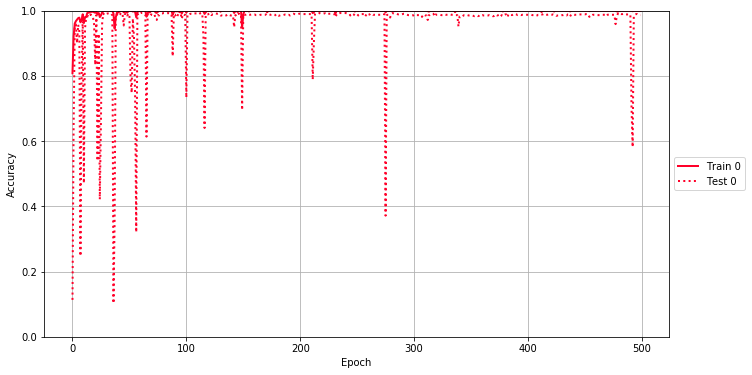

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

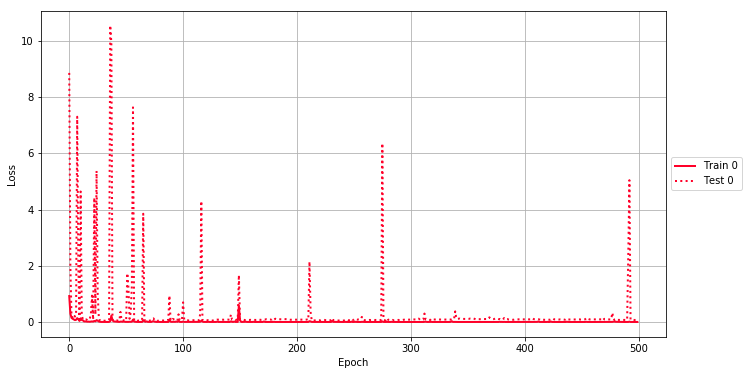

In [12]:
plot_loss(history)

Plotting the confusion matrix


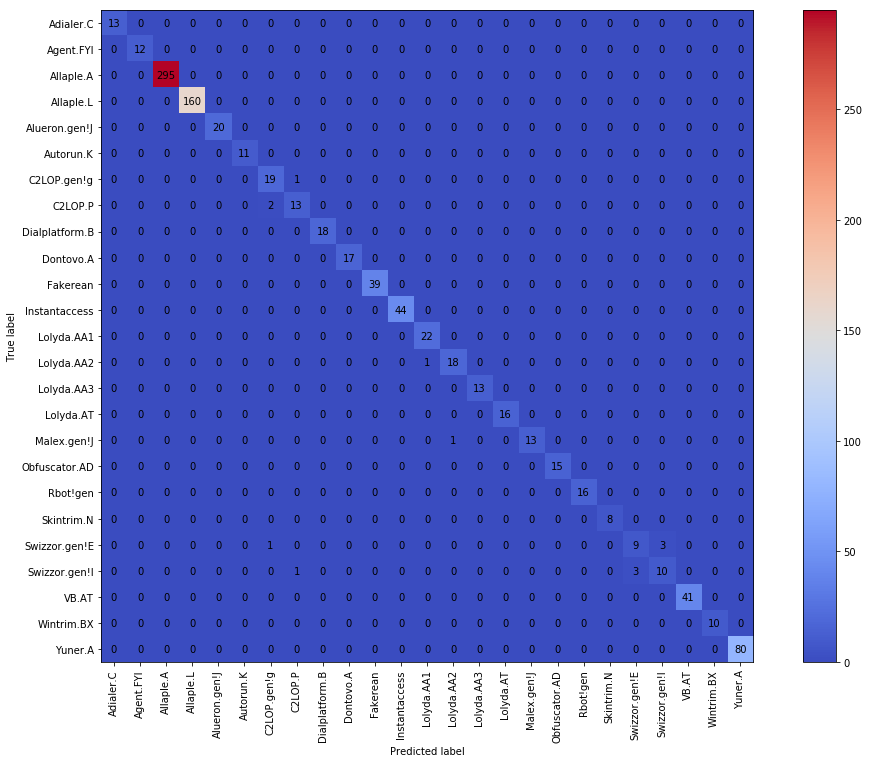

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


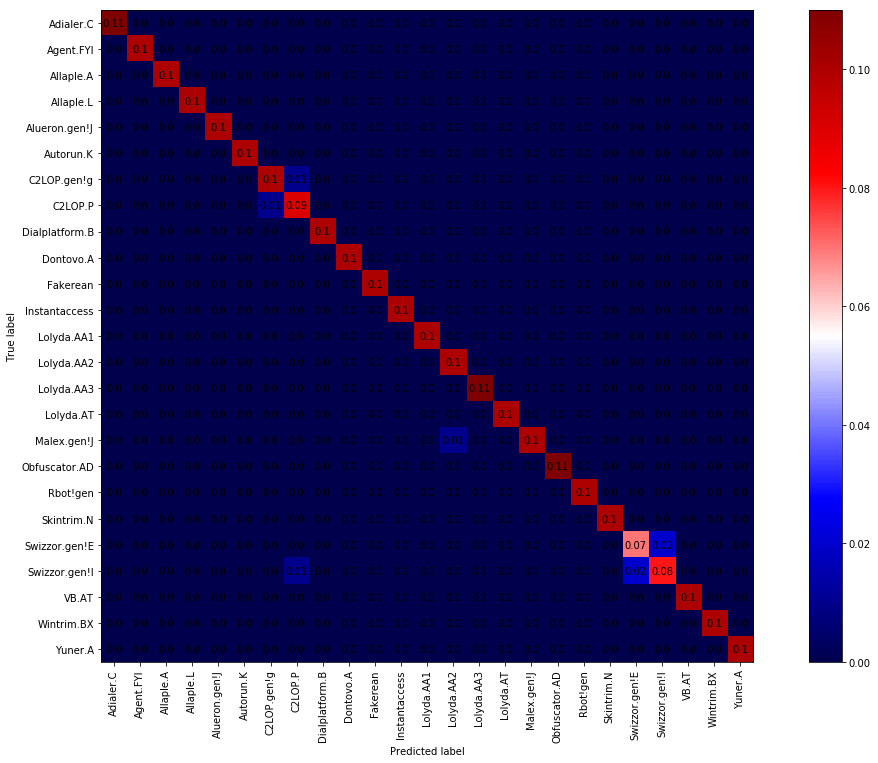

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


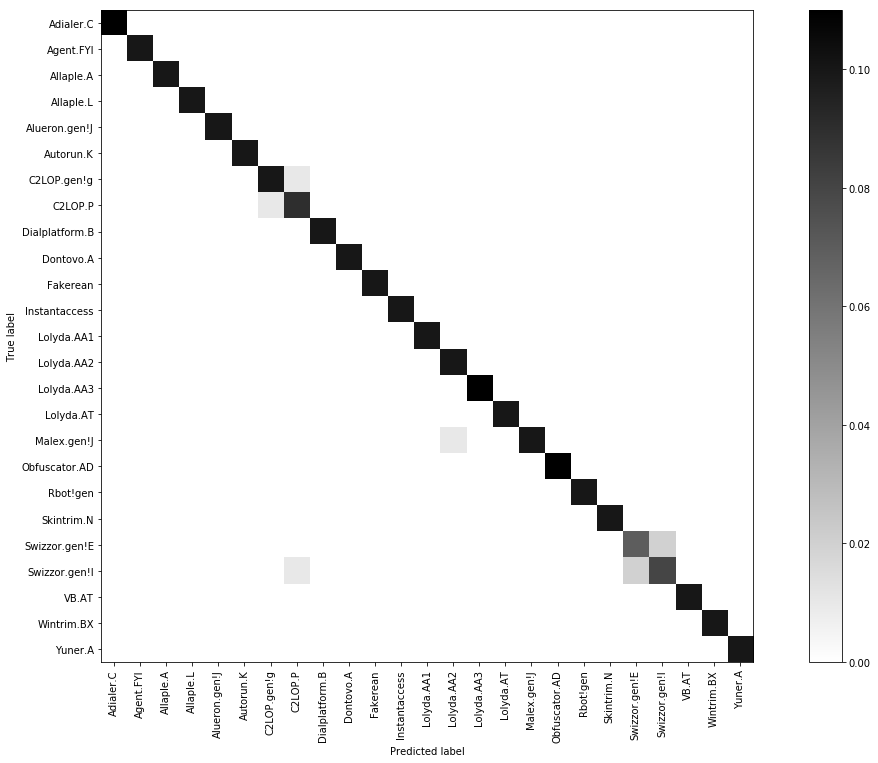

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


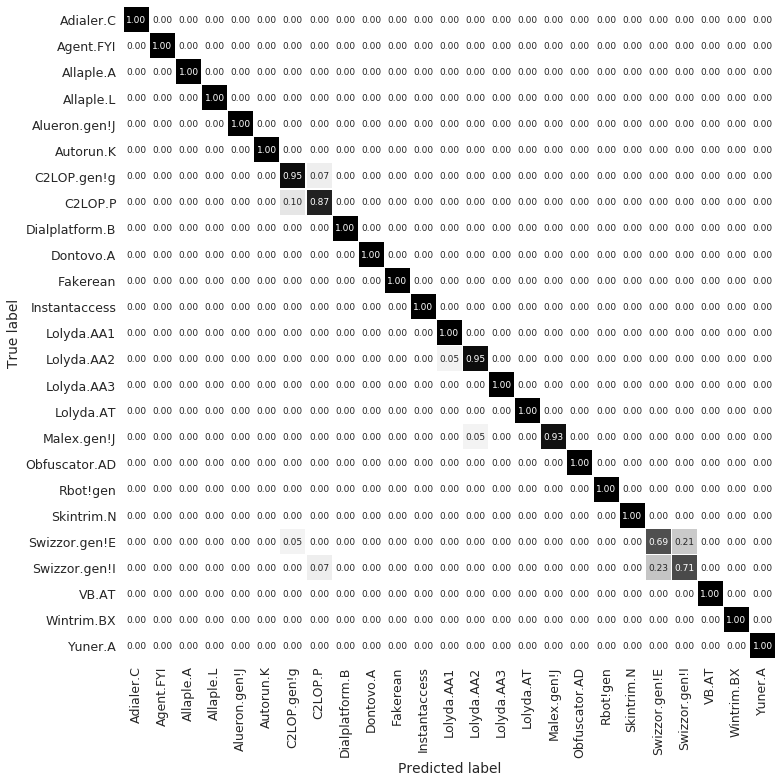

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()